
<table width="100%" style="padding:0; margin-left:-6px;">
    <tr style="padding=0;" width="100%">
        <td width="auto">
           <hr style="border:2px solid darkblue">
            <h1> nb2. Query a catalogue</h1>
           <hr style="border:2px solid darkblue">
        </td>
        <td width="60px">
           <img src="ALMAsmall.png" align="right"/> 
        </td>
    </tr>
</table>    
        
In this notebook three functions are presented which query a (moderately long) list of sources from a catalogue: 

* By ALMA source name
* By coordinate
* By resolved name

For lists with a very large number of sources, run one query per source (or per block of e.g. 100 sources)

-------------

The relevant columns in the ALMA Archive datasets are 
* *s_ra*, *s_dec* (RAD and DEC in degress)
* *target_name* (source name)
 
--------- ----- -----





In [52]:
import astropy
import astropy.coordinates
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pyvo

service = pyvo.dal.TAPService("https://almascience.eso.org/tap")      # for the EU ALMA TAP service

# service = pyvo.dal.TAPService("https://almascience.nao.ac.jp/tap")  # for the EA ALMA TAP service
# service = pyvo.dal.TAPService("https://almascience.nrao.edu/tap")   # for the NA ALMA TAP service

<hr style="border:2px solid darkblue"> </hr>


## Query list of alma souce names
<hr style="border:2px solid darkblue"> </hr>



In [53]:
def query_alma_source_name_list(service, name_list):
    """queries for list of source names as given by the PI in the ALMA proposals"""
    
    query = f"""  
            SELECT *  
            FROM ivoa.obscore  
            WHERE target_name in ('{"','".join(name_list)}') """
    
    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>

## Query list of coordinates

<hr style="border:2px solid darkblue"> </hr>


In [54]:
def query_coord_list(service, ra_list, dec_list, radius):
    """Runs a single TAP query with a list of coordinates"""
    
    conditionlist = [f"INTERSECTS(CIRCLE('ICRS',{c[0]},{c[1]},{radius}),s_region)=1" for c in zip(ra_list, dec_list)]
    
    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE {" OR ".join(conditionlist)}"""
    
    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>

## Query list of resolved names

<hr style="border:2px solid darkblue"> </hr>

In [ ]:
def query_resolved_source_name_list(service, name_list, radius):
    """Resolves the list of source names with Sesame and runs a coordinate search on them"""
    
    coordinates = []
    for source in name_list:
        try:
            coordinates.append(astropy.coordinates.SkyCoord.from_name(source))
        except astropy.coordinates.name_resolve.NameResolveError:
            print(f"Warning: source '{source}' could not be resolved by Sesame.")
            
    return query_coord_list(service, [c.ra.degree for c in coordinates], [c.dec.degree for c in coordinates], radius)
    

## Example 2a: Query a list of sources using the ALMA source name

In [56]:
source_list = ['CenA', 'M83', 'ALESS73.1'] 
results = query_alma_source_name_list(service, source_list)

results.head(5)

,access_url,access_format,proposal_id,data_rights,gal_longitude,gal_latitude,obs_publisher_did,obs_collection,facility_name,instrument_name,obs_id,dataproduct_type,calib_level,target_name,s_ra,s_dec,s_fov,s_region,s_resolution,t_min,t_max,t_exptime,t_resolution,em_min,em_max,em_res_power,pol_states,o_ucd,band_list,em_resolution,authors,pub_abstract,publication_year,proposal_abstract,schedblock_name,proposal_authors,sensitivity_10kms,cont_sensitivity_bandwidth,pwv,group_ous_uid,member_ous_uid,asdm_uid,obs_title,type,scan_intent,science_observation,spatial_scale_max,bandwidth,antenna_arrays,is_mosaic,obs_release_date,spatial_resolution,frequency_support,frequency,velocity_resolution,obs_creator_name,pub_title,first_author,qa2_passed,bib_reference,science_keyword,scientific_category,lastModified
0,http://almascience.org/aq?member_ous_id=uid://...,text/html,2011.0.00010.S,Public,309.515914,19.417224,ADS/JAO.ALMA#2011.0.00010.S,ALMA,JAO,ALMA,uid://A002/X327408/X217,cube,2,CenA,201.365063,-43.019112,0.007385,Circle ICRS 201.365063 -43.019112 0.003692,1.330912,55950.253573,55950.305961,1512.000,1512.000,0.001364,0.001369,450286.77208,/XX/YY/,phot.flux.density;phys.polarization,6,614.023326,"McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...","Centaurus A, with its gas-rich elliptical host...",2017,Centaurus A with its host NGC5128 is the most ...,"CenA 13CO, C18O, HNCO, H2CO COMP","Impellizzeri, Violette; Peck, Alison; Walter, ...",1.399871,0.061695,0.852892,,uid://A002/X327408/X217,uid://A002/X383b50/Xc45,The Physics and Chemisty of Gas in Centaurus A...,S,TARGET,T,12.599759,937500000.0,A002:PM02 A004:DV04 A009:DA43 A011:DV12 A013:D...,F,2015-02-12T13:48:59.000,1.330912,"[217.59..218.53GHz,488.28kHz,1.4mJy/beam@10km/...",219.025328,663.940713,"Ott, Juergen",ALMA Observations of the Physical and Chemical...,"McCoy, Mark",T,2017ApJ...851...76M,"Active Galactic Nuclei (AGN)/Quasars (QSO), Me...",Active galaxies,2021-08-09T17:58:23.481
1,http://almascience.org/aq?member_ous_id=uid://...,text/html,2011.0.00010.S,Public,309.515914,19.417224,ADS/JAO.ALMA#2011.0.00010.S,ALMA,JAO,ALMA,uid://A002/X327408/X217,cube,2,CenA,201.365063,-43.019112,0.007385,Circle ICRS 201.365063 -43.019112 0.003692,1.330912,55950.253573,55950.305961,1512.000,1512.000,0.001365,0.001371,449784.96600,/XX/YY/,phot.flux.density;phys.polarization,6,614.023326,"McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...","Centaurus A, with its gas-rich elliptical host...",2017,Centaurus A with its host NGC5128 is the most ...,"CenA 13CO, C18O, HNCO, H2CO COMP","Impellizzeri, Violette; Peck, Alison; Walter, ...",1.400488,0.061695,0.852892,,uid://A002/X327408/X217,uid://A002/X383b50/Xc45,The Physics and Chemisty of Gas in Centaurus A...,S,TARGET,T,12.599759,937500000.0,A002:PM02 A004:DV04 A009:DA43 A011:DV12 A013:D...,F,2015-02-12T13:48:59.000,1.330912,"[217.59..218.53GHz,488.28kHz,1.4mJy/beam@10km/...",219.025328,663.940713,"Ott, Juergen",ALMA Observations of the Physical and Chemical...,"McCoy, Mark",T,2017ApJ...851...76M,"Active Galactic Nuclei (AGN)/Quasars (QSO), Me...",Active galaxies,2021-08-09T17:58:23.481
2,http://almascience.org/aq?member_ous_id=uid://...,text/html,2011.0.00772.S,Public,314.600374,31.972870,ADS/JAO.ALMA#2011.0.00772.S,ALMA,JAO,ALMA,uid://A002/X3216af/X31,cube,2,M83,204.269845,-29.862594,0.054640,Polygon ICRS 204.258830 -29.886906 204.254315 ...,1.140462,56013.300683,56166.036243,757.304,757.304,0.002637,0.002659,232808.19800,/XX/YY/,phot.flux.density;phys.polarization,3,614.003552,"Egusa, Fumi; Hirota, Akihiko; Baba, Junichi; M...",We describe an archival project using Cycle 0 ...,2018,Molecular-rich galaxies with prominent galacti...,m83-CO(1-0)-com m83-CO(1-0)-ext,"Muraoka, Kazuyuki; Nakanishi, Kouichiro; Ishiz...",7.805726,0.278101,1.821328,,uid://A002/X3216af/X31,uid://A002/X3b3400/X90f,Giant Molecular Cloud Survey Toward bar and ar...,S,TARGET,T,11.275626,937500000.0,A003:DA41 A004:DV04 A008:DV19 A011:DV12 A015:D...,T,2013-09-28T08:06:00.000,1.140462,"

-----------------

## Example 2b: Query a catalogue of high-z quasars

First we import a catalogue of high redshift quasars from Vizier, using astroquery:

In [60]:
from astroquery.vizier import Vizier
catalog_list = Vizier.get_catalogs('J/ApJS/227/11')
highzqso_catalog = catalog_list['J/ApJS/227/11/highzqso']

We will now use the RA and DEC coordinates in the catalogue to do the search in the ALMA archive. 

In [65]:
ra_list = highzqso_catalog['RAJ2000']
dec_list = highzqso_catalog['DEJ2000']

We now query the ALMA archive:


In [66]:
results = query_coord_list(service, ra_list, dec_list, 0.01)
results.head(5) ### show only 5, for visualization purposes

DALServiceError: 502 Server Error: Proxy Error for url: https://almascience.eso.org/tap/sync/ztmx757cpo5aek61/run

We can now plot the distribution of ALMA observed quasars from the chosen catalogue.

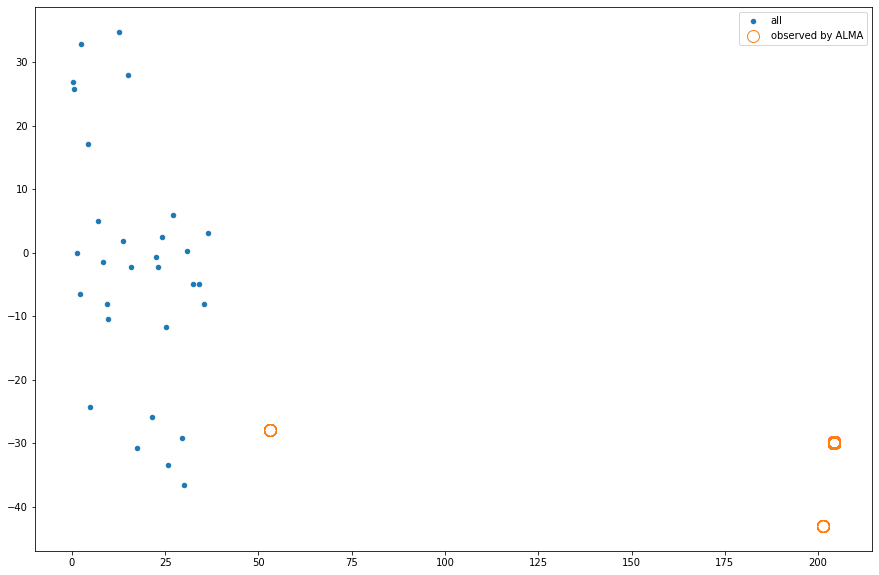

In [64]:
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (15,10)

plt.plot(ra_list, dec_list, ls='', marker='.', ms=9, label='all')
plt.plot(results['s_ra'],results['s_dec'], ls='', marker='o', ms=12, fillstyle='none', label='observed by ALMA')
plt.legend()

Please run several queries in case the number of sources in your list is very large.

-----------------

## Example 2c: Query a list of sources using a name resolver

The function query_resolved_source_name_list will query Sesame for each source name and then query the ALMA TAP service with the returned coordinates. 

In [ ]:
source_list = ['CenA', 'M83', 'ALESS73.1', 'unknownsourcename'] 
query_resolved_source_name_list(service, source_list, 0.01).head(5)

For lists with a very large number of names, split the query into chunks of e.g. 100 sources:

In [ ]:
result = [query_resolved_source_name_list(service, source_list[i:i + 100], 0.01) for i in range(0, len(source_list), 100)]